In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

2024-08-15 18:12:46.678577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 18:12:46.678717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 18:12:46.832100: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
directory = "models_training\PlantVillage"

main_classes = [
 'Tomato__Target_Spot',
 'Tomato__Tomato_mosaic_virus',
'Tomato__Tomato_YellowLeaf__Curl_Virus',
'Tomato_Bacterial_spot',
'Tomato_Early_blight',
'Tomato_healthy',
'Tomato_Late_blight',
'Tomato_Leaf_Mold',
'Tomato_Septoria_leaf_spot',
'Tomato_Spider_mites_Two_spotted_spider_mite']

dataset = keras.preprocessing.image_dataset_from_directory(
    directory,
    class_names=main_classes
)

Found 16011 files belonging to 10 classes.


In [3]:
dataset.class_names

['Tomato__Target_Spot',
 'Tomato__Tomato_mosaic_virus',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_healthy',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite']

In [4]:
len(dataset)

501

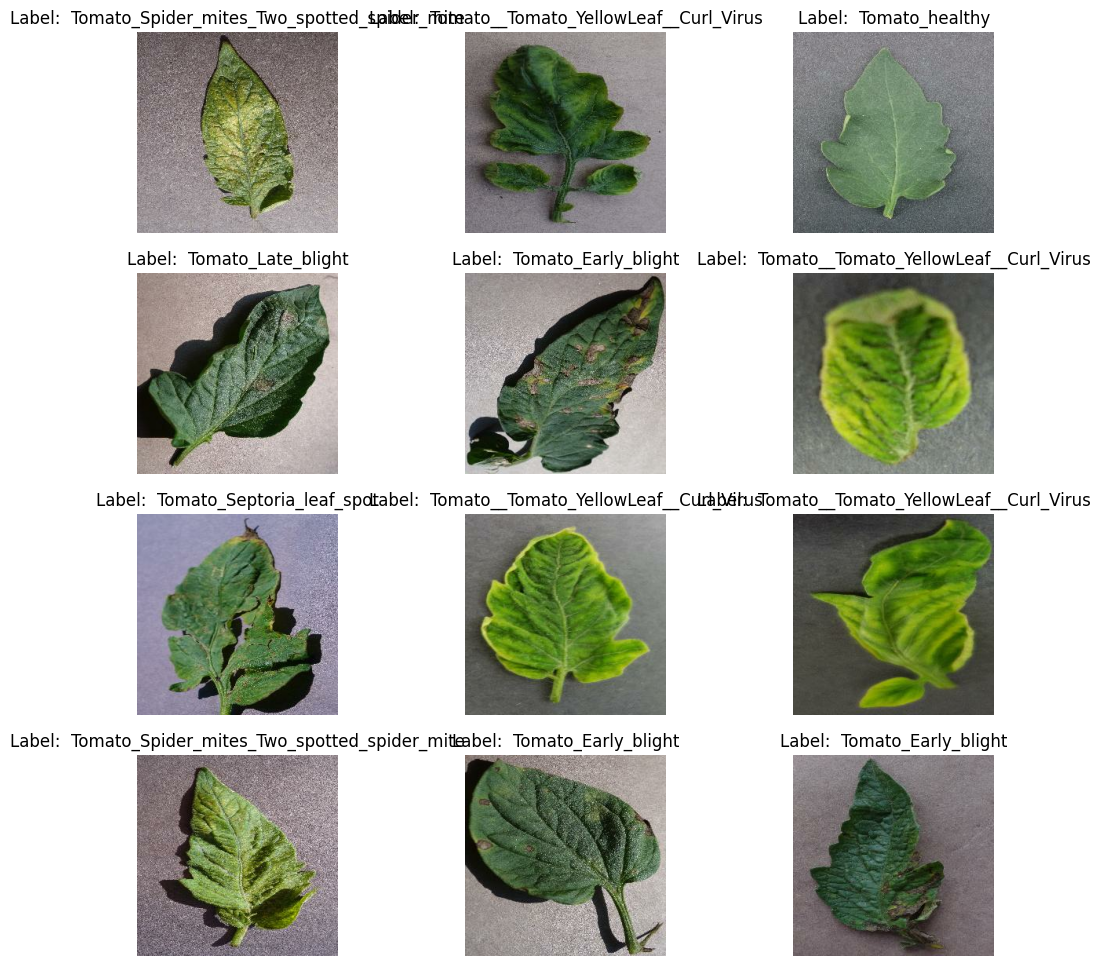

In [5]:
plt.figure(figsize=(12,12))
for image_batch, label_batch in dataset.take(1):
    for i  in range(12):
        image = image_batch[i].numpy().astype("uint8")
        label = label_batch[i].numpy()
        ax = plt.subplot(4,3,i+1)
        plt.imshow(image)
        plt.title(f"Label:  {main_classes[label]}")  
        plt.axis('off')

## splitting the dataset

In [6]:
def train_test_split(dataset,train_split=0.8,valid_split=0.1,shuffle=True):
    if shuffle:
        dataset.shuffle(2000)
    dataset_size = len(dataset)
    train_size = int(train_split * dataset_size)
    valid_size =  int(valid_split * dataset_size)
    test_size =  dataset_size - (train_size + valid_size)


    train_dataset = dataset.take(train_size)
    valid_dataset = dataset.skip(train_size).take(valid_size)
    test_dataset = dataset.skip(train_size + valid_size)

    return train_dataset,valid_dataset,test_dataset


In [7]:
train_dataset,valid_dataset,test_dataset  = train_test_split(dataset)

In [8]:
len(train_dataset)

400

In [9]:
import tensorflow as tf
train_dataset = train_dataset.shuffle(buffer_size=len(train_dataset)).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.shuffle(buffer_size=len(valid_dataset)).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(buffer_size=len(test_dataset)).prefetch(buffer_size=tf.data.AUTOTUNE)

### preprocessing

In [10]:
image_size = 256

resize_rescale = keras.Sequential([
    keras.layers.Resizing(image_size,image_size),
    keras.layers.Rescaling(1./255)
])

data_augmentation = keras.Sequential([
    # keras.layers.RandomBrightness(factor=0.2),
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(.5,.2)
])

In [11]:
batch_size, channels = 32,3
model = keras.models.Sequential([
    resize_rescale,
    data_augmentation,
    keras.layers.Conv2D(264,(3,3),activation="relu",input_shape=(batch_size,image_size,image_size,channels)),
    keras.layers.MaxPooling2D((3,3)),

    keras.layers.Conv2D(128,(3,3),activation="relu"),
    keras.layers.MaxPooling2D((3,3)),

    keras.layers.Conv2D(128,(3,3),activation="relu"),
    keras.layers.MaxPooling2D((3,3)),

    keras.layers.Conv2D(64,(3,3),activation="relu"),
    keras.layers.MaxPooling2D((3,3)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(32,activation="relu"),
    keras.layers.Dense(16,activation="relu"),
    keras.layers.Dense(8,activation="relu"),
    keras.layers.Dense(len(main_classes),activation="softmax")

])
model.build()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [14]:
with tf.device("/device:GPU:0"):
    history = model.fit(
        train_dataset,
        epochs=40,
        batch_size=32,
        verbose=1,  
        validation_data=valid_dataset
    )

Epoch 1/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 101s 156ms/step - accuracy: 0.2416 - loss: 2.0824 - val_accuracy: 0.3800 - val_loss: 1.7161
Epoch 2/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 66s 150ms/step - accuracy: 0.4169 - loss: 1.6484 - val_accuracy: 0.5487 - val_loss: 1.2363
Epoch 3/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 65s 149ms/step - accuracy: 0.5271 - loss: 1.3292 - val_accuracy: 0.5769 - val_loss: 1.1915
Epoch 4/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 65s 149ms/step - accuracy: 0.6469 - loss: 1.0193 - val_accuracy: 0.5738 - val_loss: 1.4240
Epoch 5/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 65s 149ms/step - accuracy: 0.7025 - loss: 0.8236 - val_accuracy: 0.7544 - val_loss: 0.6897
Epoch 6/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 65s 148ms/step - accuracy: 0.7581 - loss: 0.6829 - val_accuracy: 0.6938 - val_loss: 0.9016
Epoch 7/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 65s 148ms/step - accuracy: 0.7670 - loss: 0.6600 - val_accuracy: 0.7487 - val_loss: 0.7924
Epoch 8/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 65s 149ms/step - accuracy: 0.8118 - loss: 

In [22]:
model.evaluate(test_dataset)

51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9009 - loss: 0.3621


[0.35042694211006165, 0.9019242525100708]

In [23]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training & Validation loss')

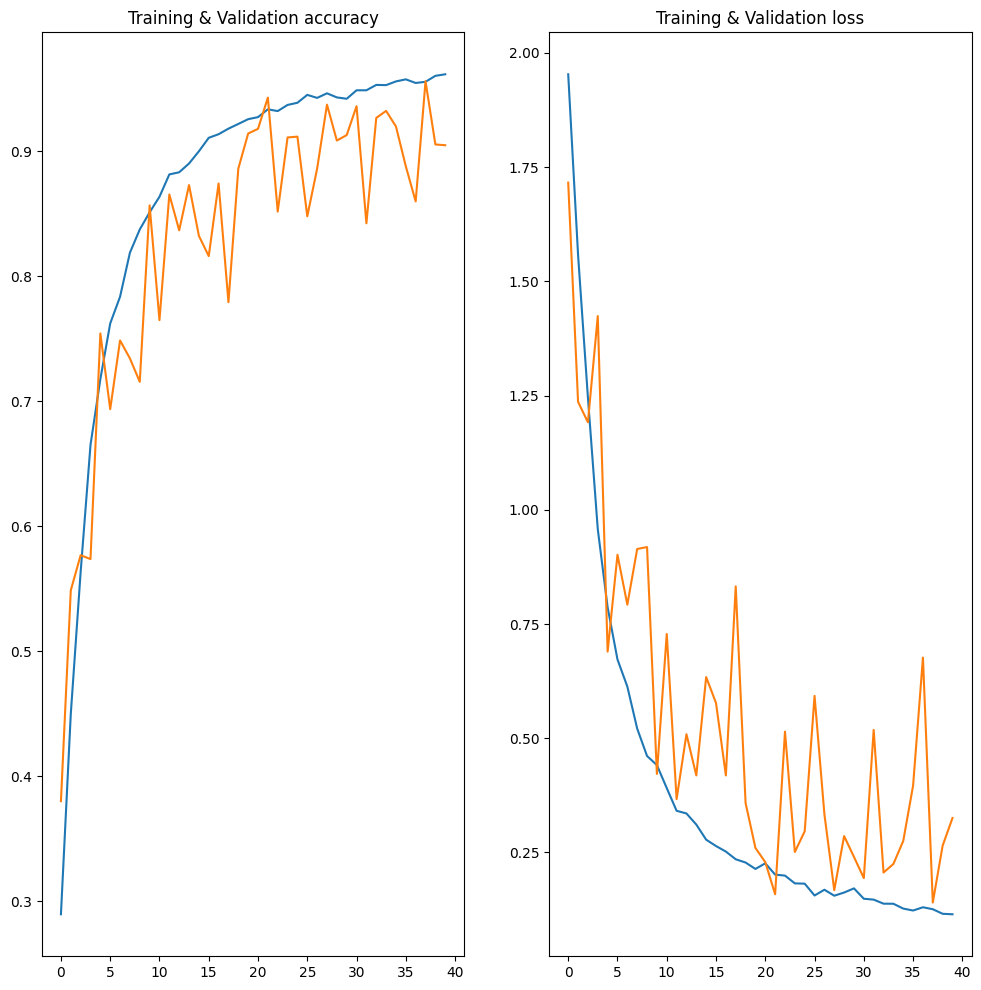

In [24]:
plt.figure(figsize=(12,12))
epochs_range  =range(history.params["epochs"])
plt.subplot(1,2,1)
plt.plot(epochs_range,accuracy,label="Training Accuracy")
plt.plot(epochs_range,val_accuracy,label="Validation Accuracy")
plt.title("Training & Validation accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label="Training loss")
plt.plot(epochs_range,val_loss,label="Validation loss")
plt.title("Training & Validation loss")

In [25]:
model.save("/kaggle/working/tomato1.keras")

In [26]:
model = keras.models.load_model("/kaggle/working/tomato.keras")

In [27]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = main_classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


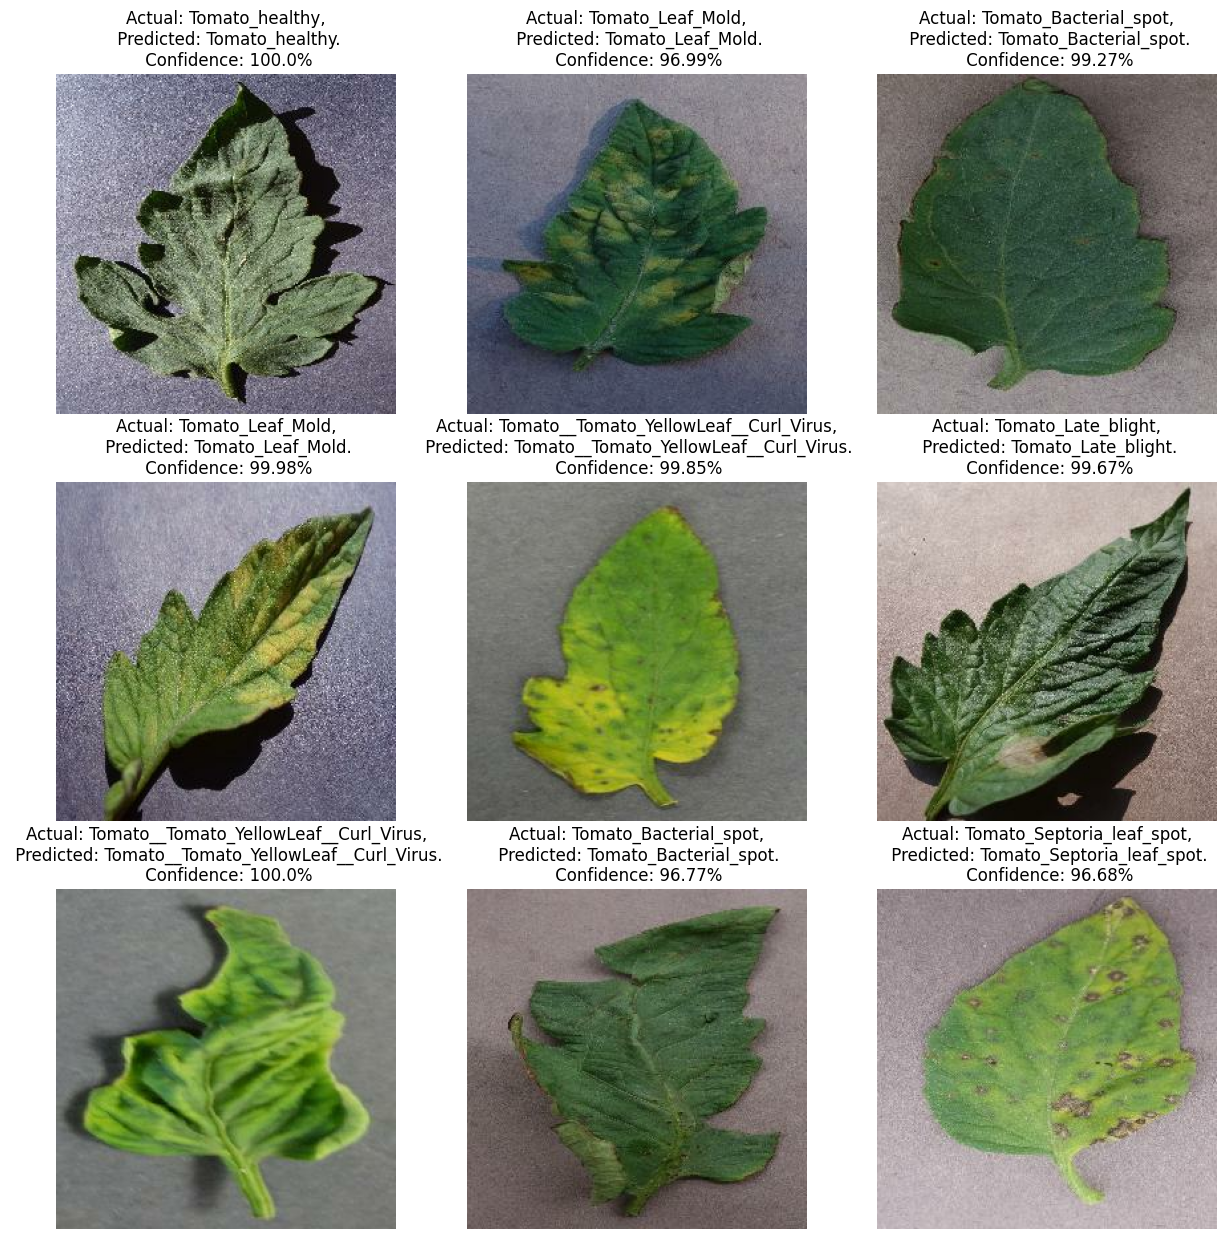

In [29]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = main_classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")